This notebook is intended to introduce and demonstrate some of the features of pyMAISE and examine the performance of machine learning models on a nuclear engineering application. For further information on the capabilities of the classes and functions shown in this notebook, please refer to the [pyMAISE API reference documentation](https://pymaise.readthedocs.io/en/latest/pymaise_api.html).


# Thermal Storage Tank DT

## Context

This simulated dataset has been generated using a digital twin (DT) of the thermal energy delivery system (TEDS) at Idaho National Laboratory (INL) for a project which focuses on uncertainty quantification of this DT.

The dataset is made for a sensitivity analysis using Sobol and FAST methods in order to identify major sources of uncertainty in a Dymola physics-based model of TEDS. To achieve this, each parameter is perturbed within the specified boundary condition interval for each sample. The sensitivity study focuses only on the thermal storage tank, while the rest of the components in TEDS, like heat exchanger, pipes, heaters, etc. are omitted. Additionally, previous analyses allowed the elimination of two parameters : outlet pressure and outlet temperature.

**Our goal is to identify optimal ML models with pyMAISE that can predict the output temperatures accurately given the previously specified input parameters and boundary conditions, and then use them for the sensitivity analysis.**

<br>

***

## Input

Input data is a 3D tensor with shape (1024, 46, 4) for (samples, timesteps, features).

There are 1024 simulations/samples, each simulation is specified with 3 input parameters + time index (total 4 features). The "timesteps" axis specifies the value of the input as a function of time for 46 timesteps of 400s.

The features in order are:

- **time** : Elapsed experiment time (s) 
- **massflow** : Inlet mass flow rate (boundary conditions : 0.0 - 2.5 $kg.m^{-1}$)
- **shape_factor** : Constant factor for tank fillers' packing scheme (boundaryconditions : 2 - 3)
- **porosity** : Constant ratio of void volume and total volume (boundary conditions : 0.2 - 0.9)

"At each timestep, **massflow** adheres to specific boundary conditions, and its overall time-dependent trajectory follows this pattern:

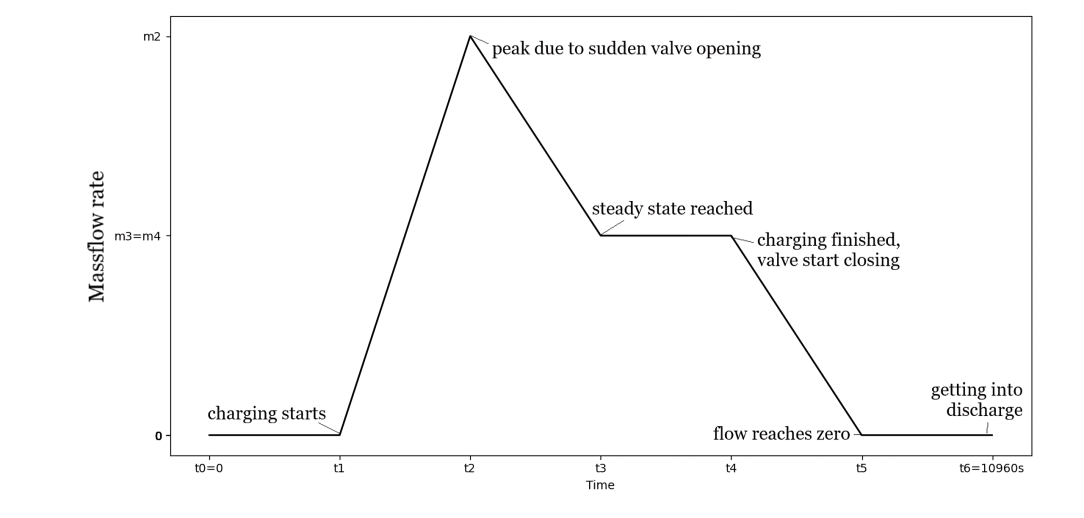

## Output

Output data is a 3D tensor with shape (1024, 13, 6) for (samples, sensors, time_slices).

There are 1024 simulations/samples, each simulation yields **temperature (K)** measurements from 13 sensors, which are distributed around the tank, for 6 specific time points : 4000s, 6000s, 8000s, 10000s, 12000s, 14000s.

Sensors are thermocouples with the following names :

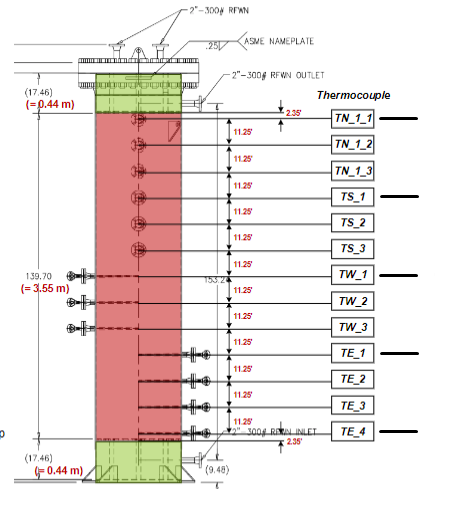

<br>

The following are a few standard packages and functions that will prove helpful while using pyMAISE along with pyMAISE-specific functionality.

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import uniform, randint
from sklearn.preprocessing import MinMaxScaler

# Plot settings
matplotlib_settings = {
    "font.size": 12,
    "legend.fontsize": 11,
    "figure.figsize": (8, 8)
}
plt.rcParams.update(**matplotlib_settings)

if not os.path.exists('results'):
    os.makedirs('results')

We need to import several functions and classes for machine learning tuning and analysis with pyMAISE. We must split the data into training/testing data and scale it. For this, we use the `pyMAISE.preprocessing` Python module. The remaining classes we can get from `pyMAISE` directly which we import as `mai` for convenience.

In [2]:
from pyMAISE.preprocessing import correlation_matrix, train_test_split, scale_data
import pyMAISE as mai

2024-08-17 14:18:25.241507: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-17 14:18:25.252327: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-17 14:18:25.255645: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-17 14:18:25.264659: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-08-17 14:18:25.819705: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## pyMAISE Initialization

Starting any pyMAISE job requires initialization. This includes the definition of global settings used throughout pyMAISE. These settings and their defaults include:

- `problem_type`: the problem type, either regression or classification, defined by `pyMAISE.ProblemType`,
- `verbosity=0`: the level of output from pyMAISE,
- `random_state=None`: the seed for the random number generator, which can be used to get reproducible results from pyMAISE,
- `num_configs_saved=5`: the number of top hyperparameter configurations for each model evaluated during tuning,
- `new_nn_architecture=True`: a boolean that dictates whether to use the old deprecated pyMAISE neural network tuning architecture,
- `cuda_visible_devices=None`: sets the `CUDA_VISIBLE_DEVICES` environment variable.

The only argument that needs to be specified is `problem_type`. We also pass `"-1"` to `cuda_visible_devices` to ensure we only use tensorflow on the CPU. This is useful for this problem since we will build relatively simple, dense feedforward neural networks with a reasonably small data set. Therefore, running tensorflow on a GPU may hurt our performance. We leave the others default, giving us five hyperparameter configurations for each model, keeping the stochastic nature of some of the algorithms, and using the current neural network hyperparameter tuning architecture.

In [3]:
global_settings = mai.init(
    problem_type=mai.ProblemType.REGRESSION,   # Define a regression problem
    cuda_visible_devices="-1"                  # Use CPU only
)

## Data Loading and Preprocessing

Our data, which is not included in the pyMAISE benchmark datasets, is initially stored as 3D tensors in two separate .npy files: one file contains the input data, and the other contains the output data. Using the `pyMAISE.preprocessing.read_csv` function is not convenient in this situation because we would need to load the .npy files, convert them into 2D arrays, merge them into one dataset, split them into train and test splits, save them in .csv files, and then reload them using the function. Refer to the [pyMAISE API reference documentation](https://pymaise.readthedocs.io/en/stable/pymaiseapi/index.html) for specifics on the use of this function.

Instead, since the primary task of the function is to convert the .csv data into xarrays, which is the data structure expected by the upcoming pyMAISE functions, we will handle the conversion using the [Xarray library](https://docs.xarray.dev/en/stable/).

First, let's import the input data :

In [4]:
x=np.load('../data/inputs.npy')

Take a look at the example below for the first input sample in the 3D tensor :

In [5]:
x_sample1 = pd.DataFrame(x[0,:,:], columns=['time','massflow','shape_factor','porosity'])
print(x_sample1)

       time  massflow  shape_factor  porosity
0       0.0  0.000000      2.236089  0.302729
1     400.0  0.000000      2.236089  0.302729
2     800.0  0.000000      2.236089  0.302729
3    1200.0  0.000000      2.236089  0.302729
4    1600.0  0.000000      2.236089  0.302729
5    2000.0  0.000000      2.236089  0.302729
6    2400.0  1.098733      2.236089  0.302729
7    2800.0  1.581339      2.236089  0.302729
8    3200.0  1.289122      2.236089  0.302729
9    3600.0  0.996905      2.236089  0.302729
10   4000.0  0.704688      2.236089  0.302729
11   4400.0  0.591506      2.236089  0.302729
12   4800.0  0.579957      2.236089  0.302729
13   5200.0  0.568407      2.236089  0.302729
14   5600.0  0.556857      2.236089  0.302729
15   6000.0  0.545308      2.236089  0.302729
16   6400.0  0.533758      2.236089  0.302729
17   6800.0  0.522208      2.236089  0.302729
18   7200.0  0.510658      2.236089  0.302729
19   7600.0  0.499109      2.236089  0.302729
20   8000.0  0.480409      2.23608

Let's convert x into a 2D array with dimensions (samples, features). We'll discard the 'time' feature, which is just a linear function of time_steps, retain the two static features, and treat massflow(t) for each time t as separate features. Some of the massflow(t) features always have a value of zero (please refer to the diagram in the [**Input**](#Input) section) so we will discard them too. We end up with a neat total of 20 input features.

In [6]:
# Flatten x into a 2D array
x = np.concatenate([x[:, 0, 2:], x[:, :, 1]], axis=1) #[x_static, x_dynamic]

# Get rid of unuseful massflow values
x = np.delete(x, np.s_[26:], axis=1)
x = np.delete(x, np.s_[2:8], axis=1)

Now let's import the output data :

In [7]:
y=np.load('../data/outputs.npy')

Based on our preliminary observations that sensors located close to each other show high correlation, we will retain only the 5 most meaningful sensors, resulting in keeping one sensor out of three :

In [8]:
y = y[:, ::3, :]

We then flatten y into a 2D array with dimensions (samples, features), resulting in 30 output features : 5 sensors times 6 timesteps.

In [9]:
y = np.reshape(y, (len(y), -1))

Finally, we name the input and output features and convert them into xarrays. The output features are named using the thermocouple names listed in the [**Output**](#Output) section, only those marked with a black bar are used.

In [10]:
# Name the input features, no need to name the samples
name_x = ["sf", "por"]
msf_indices = np.array(range(46))
msf_indices = np.delete(msf_indices, np.s_[24:]) #the indices have to match to the correct massflow(t) feature
msf_indices = np.delete(msf_indices, np.s_[0:6])
for i in msf_indices:
    name_x.append("msf_%d" %i)

# Name the output features, no need to name the samples
sensor_names = ["TE_4", "TE_1", "TW_1", "TS_1", "TN_1_1"]
name_y = [["%s_t4000"%name, "%s_t6000"%name, "%s_t8000"%name, "%s_t10000"%name, "%s_t12000"%name, "%s_t14000"%name,]
            for name in sensor_names]
name_y = np.concatenate(name_y)

# Convert np arrays into xarrays
x = xr.DataArray(x, name="Input data", dims=["Samples", "Features"], coords={"Features":name_x})
y = xr.DataArray(y, name="Target data",dims=["Samples", "Features"], coords={"Features":name_y})

We end up with the following features in order :

**Input**

- `sf`: Constant factor for tank fillers' packing scheme (boundaryconditions : 2 - 3)
- `por`: Constant ratio of void volume and total volume (boundary conditions : 0.2 - 0.9)
- `msf_6` : Inlet mass flow rate after 7 timesteps of elapsed time (boundary conditions : 0.19 - 1.65 $kg.m^{-1}$)
- `msf_7` : Inlet mass flow rate after 8 timesteps of elapsed time (boundary conditions : 0.66 - 2.48 $kg.m^{-1}$)
<br>**.**
<br>**.**
<br>**.**
- `msf_22` : Inlet mass flow rate after 23 timesteps of elapsed time (boundary conditions : 0.06 - 0.21 $kg.m^{-1}$)
- `msf_23` : Inlet mass flow rate after 24 timesteps of elapsed time (boundary conditions : 0.00 - 0.01 $kg.m^{-1}$)

**Output**

- `TE_4_t4000` : Inlet emperature reading from the 4th east thermocouple after 4000s of elapsed time ($K$)
- `TE_1_t4000` : Inlet temperature reading from the 1st east thermocouple after 4000s of elapsed time ($K$)
<br>**.**
<br>**.**
<br>**.**
- `TS_1_t14000` : Inlet temperature reading from the 1st south thermocouple after 14000s of elapsed time ($K$)
- `TN_1_1_t14000` : Inlet temperature reading from the 1st north thermocouple after 14000s of elapsed time ($K$)

***
<br>

With the data formatted, we can now continue with preprocessing using pyMAISE functions. This includes splitting into training and testing data sets and scaling. For splitting, we use the `pyMAISE.preprocessing.train_test_split` function and define the fraction of data for testing using `test_size`. On this dataset, we take 20% of the data for testing. The result is a tuple of data: `(xtrain, xtest, ytrain, ytest)`. We can then scale this data using `pyMAISE.preprocessing.scale_data` with any object that supports `fit_transform` and `transform` functions. Common scalers include [sklearn.preprocessing.MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) and [sklearn.preprocessing.StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler). Many machine learning models learn best with scaled data. We use min-max scaling on both the input and output data for this data set. `pyMAISE.preprocessing.scale_data` returns the scaled data, and the scaler fits the data. These scalers are used in postprocessing to evaluate the performance of the models.

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split([x, y], test_size=0.2)
X_train, X_test, X_scaler = scale_data(X_train, X_test, scaler=MinMaxScaler())
Y_train, Y_test, Y_scaler = scale_data(Y_train, Y_test, scaler=MinMaxScaler())

The shape of the input and output data for both the training and test sets are listed below

In [12]:
print('Training input and output shapes:', X_train.shape, Y_train.shape)
print('Testing input and output shapes:', X_test.shape, Y_test.shape)

Training input and output shapes: (819, 20) (819, 30)
Testing input and output shapes: (205, 20) (205, 30)


To get a better understanding of this data set lets plot correlation matrices of the data using `pyMAISE.preprocessing.correlation_matrix`.

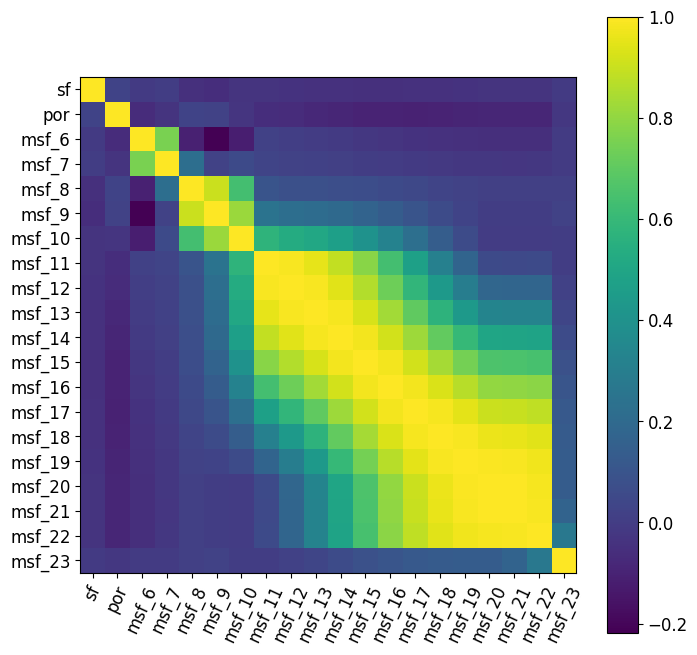

In [13]:
correlation_matrix(x)
plt.savefig('results/corr_x.png', dpi=300, bbox_inches='tight')

We can see that shape factor and porosity are uncorrelated with other features, which makes sense since they are sampled independently of them. We also notice that massflow during timesteps 11 through 22 is highly correlated, corresponding to the time interval where massflow remains relatively stable.

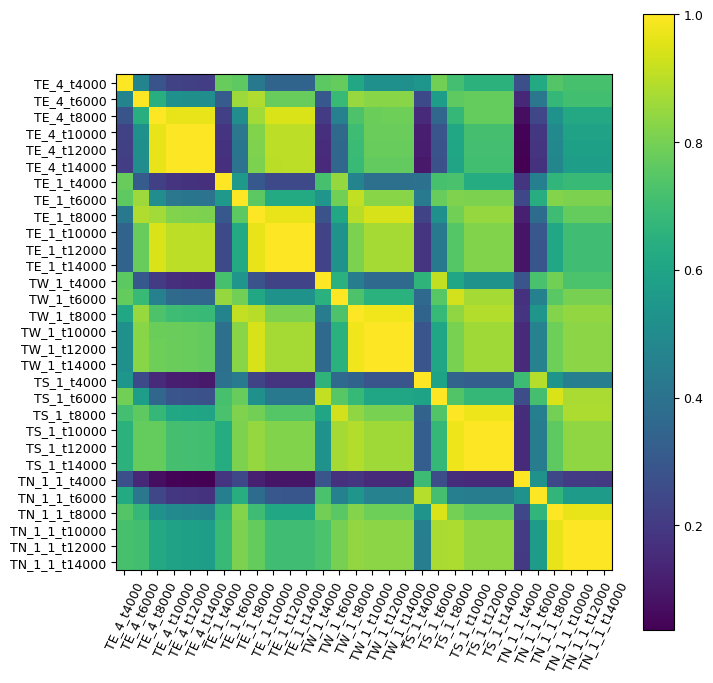

In [14]:
plt.rcParams.update({'font.size': 9}) # update font size for readability
correlation_matrix(y)
plt.savefig('results/corr_y.png', dpi=300, bbox_inches='tight')
plt.rcParams.update({'font.size': 9}) # update font size to initial font size

Here, for each sensor, the first two time readings are uncorrelated with the others, while the subsequent readings are highly correlated, reflecting a period when the inlet temperature remains relatively stable, similar to the inlet massflow rate's.

## Model Initialization

For model initialization and tuning, we use the `pyMAISE.Tuner`. pyMAISE supports both classical ML methods with [scikit-learn](https://scikit-learn.org/stable/index.html) and sequential neural networks with [Keras](https://keras.io/). We strongly recommend you refer to `pyMAISE.Tuner` in the [pyMAISE API reference documentation](https://pymaise.readthedocs.io/en/latest/pymaise_api.html) for a list of supported models, neural network layers, and other information crucial for optimal tuning. We can define all the models we wish to hyperparameter tune using a dictionary. For the this data set, we define the following regression models with their dictionary keys:

- linear: `"Linear"`,
- lasso: `"Lasso"`,
- decision tree: `"DT"`,
- random forest: `"RF"`,
- k-nearest neighbors: `"KN"`,
- feedforward neural network: `"FNN"`.

pyMAISE uses the dictionary keys for classical models to determine which [scikit-learn](https://scikit-learn.org/stable/index.html) model you request. If the keys do not match any supported keys, then it is assumed to be a neural network. In the `"models"` key, we define these models in a list. We can then define the hyperparameters for classical models, which will remain constant throughout tuning. These parameters must only be defined if you want something different from the default. Refer to the model documentation in [scikit-learn](https://scikit-learn.org/stable/index.html) for hyperparameters and defaults.

For the neural network model, we need to define the architecture, optimizer, compiling, and fitting parameters under the `"structural_params"`, `"optimizer"`, `"compile_params"`, and `"fitting_params"` keys. These parameters include those that remain constant and change during tuning. To define hyperparameters for tuning, we use the `pyMAISE.Int`, `pyMAISE.Float`, `pyMAISE.Choice`, `pyMAISE.Boolean`, and `pyMAISE.Fixed` classes. These classes are wrappers for [KerasTuner](https://keras.io/keras_tuner/). 

To define the model architecture, we use the supported Keras layers defined in the [pyMAISE API reference documentation](https://pymaise.readthedocs.io/en/latest/pymaise_api.html) under the `pyMAISE.Tuner`. These layers must differ in name, but use the base layer name. Within the layers, pyMAISE supports additional hyperparameters, which include `"sublayer"`, `"wrapper"`, and `"num_layers"` to define sublayers, wrappers (such as [keras.layers.TimeDistributed](https://keras.io/api/layers/recurrent_layers/time_distributed/)), and the number of layers.

We can then pass all this information to `pyMAISE.Tuner`.

In [15]:
model_settings = {
    "models": ["Linear", "Lasso", "DT", "RF", "KN", "FNN"],
    "FNN": {
        "structural_params": {
            "Dense_input": {
                "units": mai.Int(min_value=50, max_value=1000),
                "input_dim": X_train.shape[-1],
                "activation": "relu",
                "kernel_initializer": "normal",
                "sublayer": mai.Choice(["Dropout", "None"]),
                "Dropout": {
                    "rate": mai.Float(min_value=0.4, max_value=0.6),
                },
            },
            "Dense_hidden": {
                "num_layers": mai.Int(min_value=0, max_value=5),
                "units": mai.Int(min_value=50, max_value=1000),
                "activation": "relu",
                "kernel_initializer": "normal",
                "sublayer": mai.Choice(["Dropout_hidden", "None"]),
                "Dropout_hidden": {
                    "rate": mai.Float(min_value=0.4, max_value=0.6),
                },
            },
            "Dense_output": {
                "units": Y_train.shape[-1],
                "activation": "linear",
                "kernel_initializer": "normal",
            },
        },
        "optimizer": "Adam",
        "Adam": {
            "learning_rate": mai.Float(min_value=1e-5, max_value=0.002),
        },
        "compile_params": {
            "loss": "mean_absolute_error",
            "metrics": ["mean_absolute_error"],
        },
        "fitting_params": {
            "batch_size": mai.Choice([8, 16, 32]),
            "epochs": 50,
            "validation_split": 0.15,
        },
    },
}
tuner = mai.Tuner(X_train, Y_train, model_settings=model_settings)

## Hyperparameter Tuning

Hyperparameter tuning is split into two options: classical model and neural network tuning. For the classical models, pyMAISE supports grid, random, and Bayesian search. For the neural network models, pyMAISE supports grid, random, Bayesian, and hyperband search. All search methods use cross-validation.

We define the hyperparameter search space for the classical models by defining the arrays, distributions, or [skopt.space.space](https://scikit-optimize.github.io/stable/modules/classes.html#module-skopt.space.space) for each hyperparameter we plan to tune. We describe these within subdictionaries within the model keys. For this problem, we use `pyMAISE.Tuner.random_search` with 300 iterations as the data set is relatively small and the classical models are computationally cheap. For these models, we define the search space using [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html).

We do not hyperparameter tune linear regression because the hyperparameter options are limited, and the default scikit-learn model performs well on linear problems.

Since we have already defined the feedforward neural network search space in the previous section, all we need to do is call the search method function. For these NNs, we can call `pyMAISE.Tuner.nn_bayesian_search` with 100 iterations as NNs tend to be more computationally expensive to train over the classical models, and the Bayesian optimization may converge on the optimal model with fewer iterations.

We set `cv` for both methods to 5, which gives us five cross-validation splits for each model. This will avoid overfitting. Therefore, for each classical model, we run 1500 hyperparameter configurations, and for the neural networks, we run 500 hyperparameter configurations.

In [16]:
random_search_spaces = {
    "Lasso": {
        "alpha": uniform(loc=0.0001, scale=0.5), # 0.0001 - 0.01
    },
    "DT": {
        "max_depth": randint(low=5, high=50), # 5 - 50
        "max_features": [None, "sqrt", "log2", 5, 10, 15, 20],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
    },
    "RF": {
        "n_estimators": randint(low=50, high=200), # 50 - 200
        "criterion": ["squared_error", "absolute_error", "poisson"],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
        "max_features": [None, "sqrt", "log2", 5, 10, 15, 20],
    },
    "KN": {
        "n_neighbors": randint(low=1, high=20), # 1 - 20
        "weights": ["uniform", "distance"],
        "leaf_size": randint(low=1, high=30), # 1 - 30
        "p": randint(low=1, high=10), # 1 - 10
    }
}

start_time = datetime.now()
random_search_configs = tuner.random_search(
    param_spaces=random_search_spaces, 
    n_iter=300, 
    cv=5,
)
bayesian_search_configs = tuner.nn_bayesian_search(
    objective="r2_score",
    max_trials=100,
    cv=5,
)

print("Hyperparameter tuning took " + str(datetime.now() - start_time) + " to process.")

Trial 100 Complete [00h 01m 09s]
r2_score: 0.8804304979604355

Best r2_score So Far: 0.9076737155320199
Total elapsed time: 00h 59m 38s
Hyperparameter tuning took 5:31:52.423563 to process.


After the training, we can see training results for each iteration using the `pyMAISE.Tuner.convergence_plot` function. For the neural networks, we have the following: 

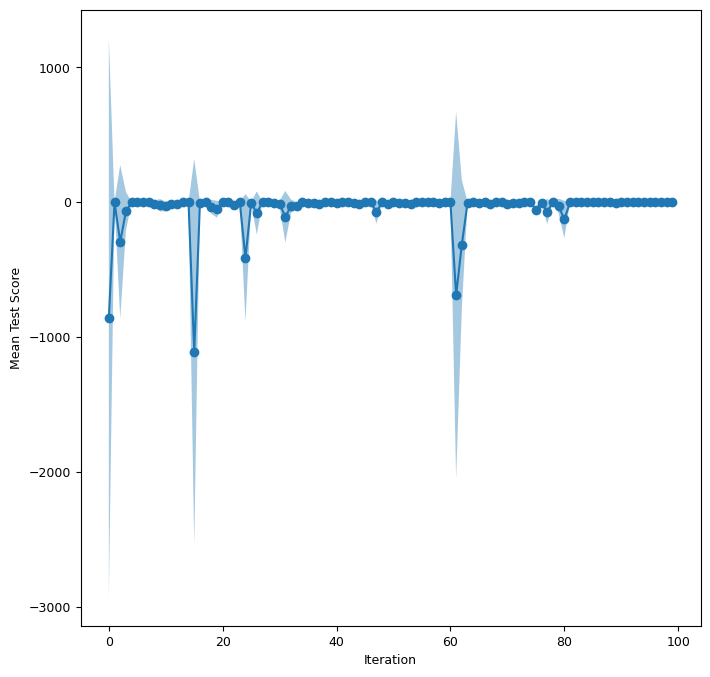

In [17]:
plt.figure()
ax = tuner.convergence_plot(model_types="FNN")
plt.savefig('results/conv_plot.png', dpi=300, bbox_inches='tight')

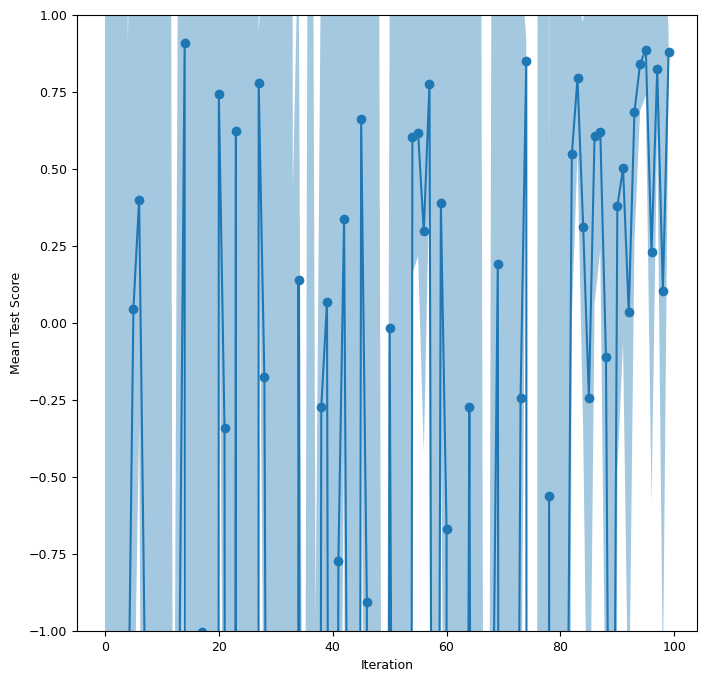

In [18]:
plt.figure()
ax = tuner.convergence_plot(model_types="FNN")
ax.set_ylim([-1, 1])
plt.savefig('results/conv_plot_zoomed.png', dpi=300, bbox_inches='tight')

The Bayesian search explores the search space but finds several suitable hyperparameter configurations despite many misfits, as indicated by parts of the curve dipping below the zero threshold.

## Model Postprocessing

With the models tuned and the top `pyMAISE.Settings.num_configs_saved` saved, we can now pass these models to the `pyMAISE.PostProcessor` for model comparison and analysis. Additionally, we can update some hyperparameters after tuning. For this data set, we changed the number of FNN epochs to 300 since we are only running five models. We give the `pyMAISE.PostProcessor` all the scaled data, the model configurations, the new model settings, and the output scaler.

In [19]:
postprocessor = mai.PostProcessor(
    data=(X_train, X_test, Y_train, Y_test), 
    model_configs=[random_search_configs, bayesian_search_configs], 
    new_model_settings={
        "FNN": {"fitting_params": {"epochs": 300}},
    },
    yscaler=Y_scaler,
)

/home/seydous/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.115e-03, tolerance: 3.806e-03
  model = cd_fast.enet_coordinate_descent(
/home/seydous/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.955e-03, tolerance: 2.003e-03
  model = cd_fast.enet_coordinate_descent(
/home/seydous/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/home/seydous/miniconda3/envs/pymaise/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 



1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step



 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 



1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step



 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 



1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step



 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 



1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step



 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 



1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step


We can now evaluate the performance of the models using the `pyMAISE.PostProcessor.metrics` function. This returns an ordered table with training and testing performance metrics. By default, `pyMAISE.PostProcessor.metrics` evaluates the training and testing $R^2$, mean absolute error (MAE), mean squared error (MSE), and root mean squared error (RMSE) for regression problems. The table is sorted by descending testing $R^2$. We can also add additional metrics, sort by a different metric, or choose the output pyMAISE computes the metrics with. Since we have multiple outputs, the metrics are calculated for each output and then averaged. For further functionality on `pyMAISE.PostProcessor.metrics` refer to the [pyMAISE API reference documentation](https://pymaise.readthedocs.io/en/latest/pymaise_api.html).

In [20]:
postprocessor.metrics().to_csv("results/metrics.csv", index=False)
postprocessor.metrics()

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
25,FNN,"{'Dense_input_0_units': 812, 'Dense_input_0_su...",0.996599,0.606925,1.106492,1.051899,0.994569,0.672715,1.415956,1.189939
22,FNN,"{'Dense_input_0_units': 1000, 'Dense_input_0_s...",0.994108,1.184876,4.819662,2.195373,0.991145,1.252330,5.561392,2.358260
24,FNN,"{'Dense_input_0_units': 269, 'Dense_input_0_su...",0.983283,1.640804,7.634943,2.763140,0.980293,1.760157,9.044491,3.007406
21,FNN,"{'Dense_input_0_units': 467, 'Dense_input_0_su...",0.979807,1.593190,7.851402,2.802035,0.979390,1.632956,8.640442,2.939463
23,FNN,"{'Dense_input_0_units': 604, 'Dense_input_0_su...",0.984440,1.645731,7.966443,2.822489,0.973908,1.879188,10.370081,3.220261
11,RF,"{'criterion': 'poisson', 'max_features': 15, '...",0.972164,2.297683,16.367241,4.045645,0.907567,4.437910,63.247870,7.952853
12,RF,"{'criterion': 'poisson', 'max_features': None,...",0.957906,2.745091,22.111905,4.702330,0.888951,4.752906,71.407787,8.450313
14,RF,"{'criterion': 'poisson', 'max_features': None,...",0.952433,2.894878,25.165789,5.016551,0.886757,4.859439,75.719879,8.701717
15,RF,"{'criterion': 'squared_error', 'max_features':...",0.940627,3.235594,32.559795,5.706119,0.883171,4.896477,75.645599,8.697448
13,RF,"{'criterion': 'poisson', 'max_features': None,...",0.950828,2.957927,25.422657,5.042089,0.882941,4.933763,78.370601,8.852717


We observe outstanding results from the best FNN, with an average MAE under 2 $K$, which translates to less than 0.5% of the temperatures recorded, and an average R2 score over 0.99, overshadowing completely the classical ML algorithms' best results ! However, this performance came at the cost of *increased* complexity.

Using the `pyMAISE.PostProcessor.get_params` function, we can see all the top performing (based on test $R^2$) models' hyperparameters.

In [21]:
for model in ["Lasso", "DT", "RF", "KN", "FNN"]:
    for key, value in postprocessor.get_params(model_type=model).to_dict().items():
        print(f"{key}: {value[0]}")
    print()

Model Types: Lasso
alpha: 0.002125322276088037

Model Types: DT
max_depth: 42
max_features: 15
min_samples_leaf: 3
min_samples_split: 8

Model Types: RF
criterion: poisson
max_features: 15
min_samples_leaf: 1
min_samples_split: 4
n_estimators: 54

Model Types: KN
leaf_size: 14
n_neighbors: 8
p: 3
weights: distance

Model Types: FNN
Dense_input_0_units: 812
Dense_input_0_sublayer: None
Dense_input_0_sublayer_Dropout_0_rate: 0.4
Dense_hidden_num_layers: 1
Adam_learning_rate: 0.0009640651652946643
Dense_hidden_0_units: 576
Dense_hidden_0_sublayer: None
Dense_hidden_0_sublayer_Dropout_hidden_0_rate: 0.5145350167199157
batch_size: 8
Dense_hidden_1_units: 606
Dense_hidden_1_sublayer: None
Dense_hidden_1_sublayer_Dropout_hidden_0_rate: 0.49276975646639515
Dense_hidden_2_units: 813
Dense_hidden_2_sublayer: None
Dense_hidden_2_sublayer_Dropout_hidden_0_rate: 0.5325297617767285
Dense_hidden_3_units: 364
Dense_hidden_3_sublayer: Dropout_hidden
Dense_hidden_3_sublayer_Dropout_hidden_0_rate: 0.5706

Note parameters such as `Dense_input_0_sublayer_Dropout_0_rate` have a value despite `Dense_input_0_sublayer="None"`. This is a product of the hyperparameter recording of KerasTuner. Even though `Dense_input_0_sublayer_Dropout_0_rate` has a value, there does not exist a `Dense_input_0_sublayer_Dropout_0` layer in the top performing FNN model.

We can use the `pyMAISE.PostProcessor.diagonal_validation_plot` and `pyMAISE.PostProcessor.validation_plot` functions to visualize the performance of these models. Diagonal validation plots show the actual versus predicted outcome. A well-performing model follows $y=x$ on this plot. You can choose what outputs to display on the diagonal validation plot; however, since all outputs have the same units, we can display all of them. Both functions use the top-performing model on test $R^2$ by default.

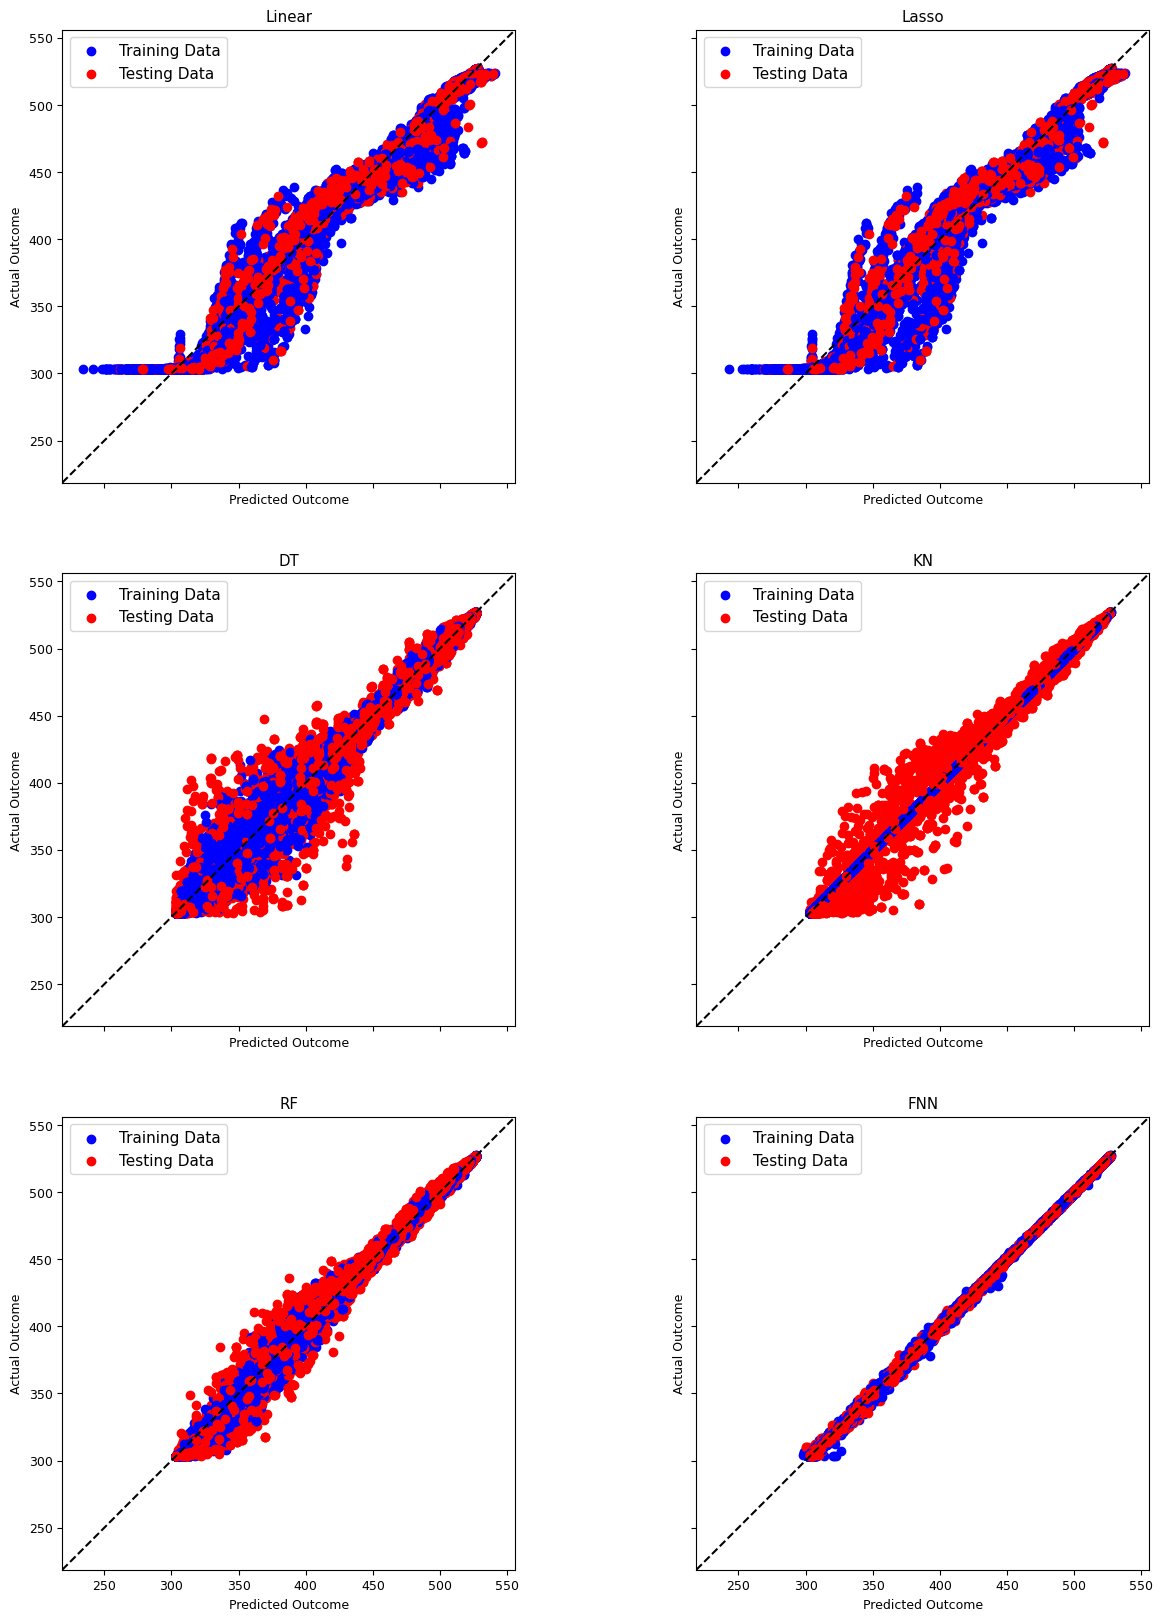

In [22]:
models = np.array([["Linear", "Lasso"], ["DT", "KN"], ["RF", "FNN"]])
fig, axarr = plt.subplots(models.shape[0], models.shape[1], sharex=True, sharey=True, figsize=(15,20))
for i in range(models.shape[0]):
    for j in range(models.shape[1]):
        plt.sca(axarr[i, j])
        axarr[i, j] = postprocessor.diagonal_validation_plot(model_type=models[i, j])
        axarr[i, j].set_title(models[i, j])
fig.savefig('results/diag_plot.png', dpi=300, bbox_inches='tight')

The FNNs performed exceptionally well, with results displaying an impressively tight spread very close to $y = x$. k-nearest neighbors and random forests did pretty good ; however the lack of performance of the decision trees, linear regressions, and lasso regressions is apparent, given the more extensive spread.

Validation plots show the absolute error of the predicted output relative to the actual outputs of the testing data set. The function can evaluate all output or show just what is given in a list. This list can include column positions in the data set or the output names. All the outputs for an elapsed time of 4000 seconds are shown in the validation plot below.

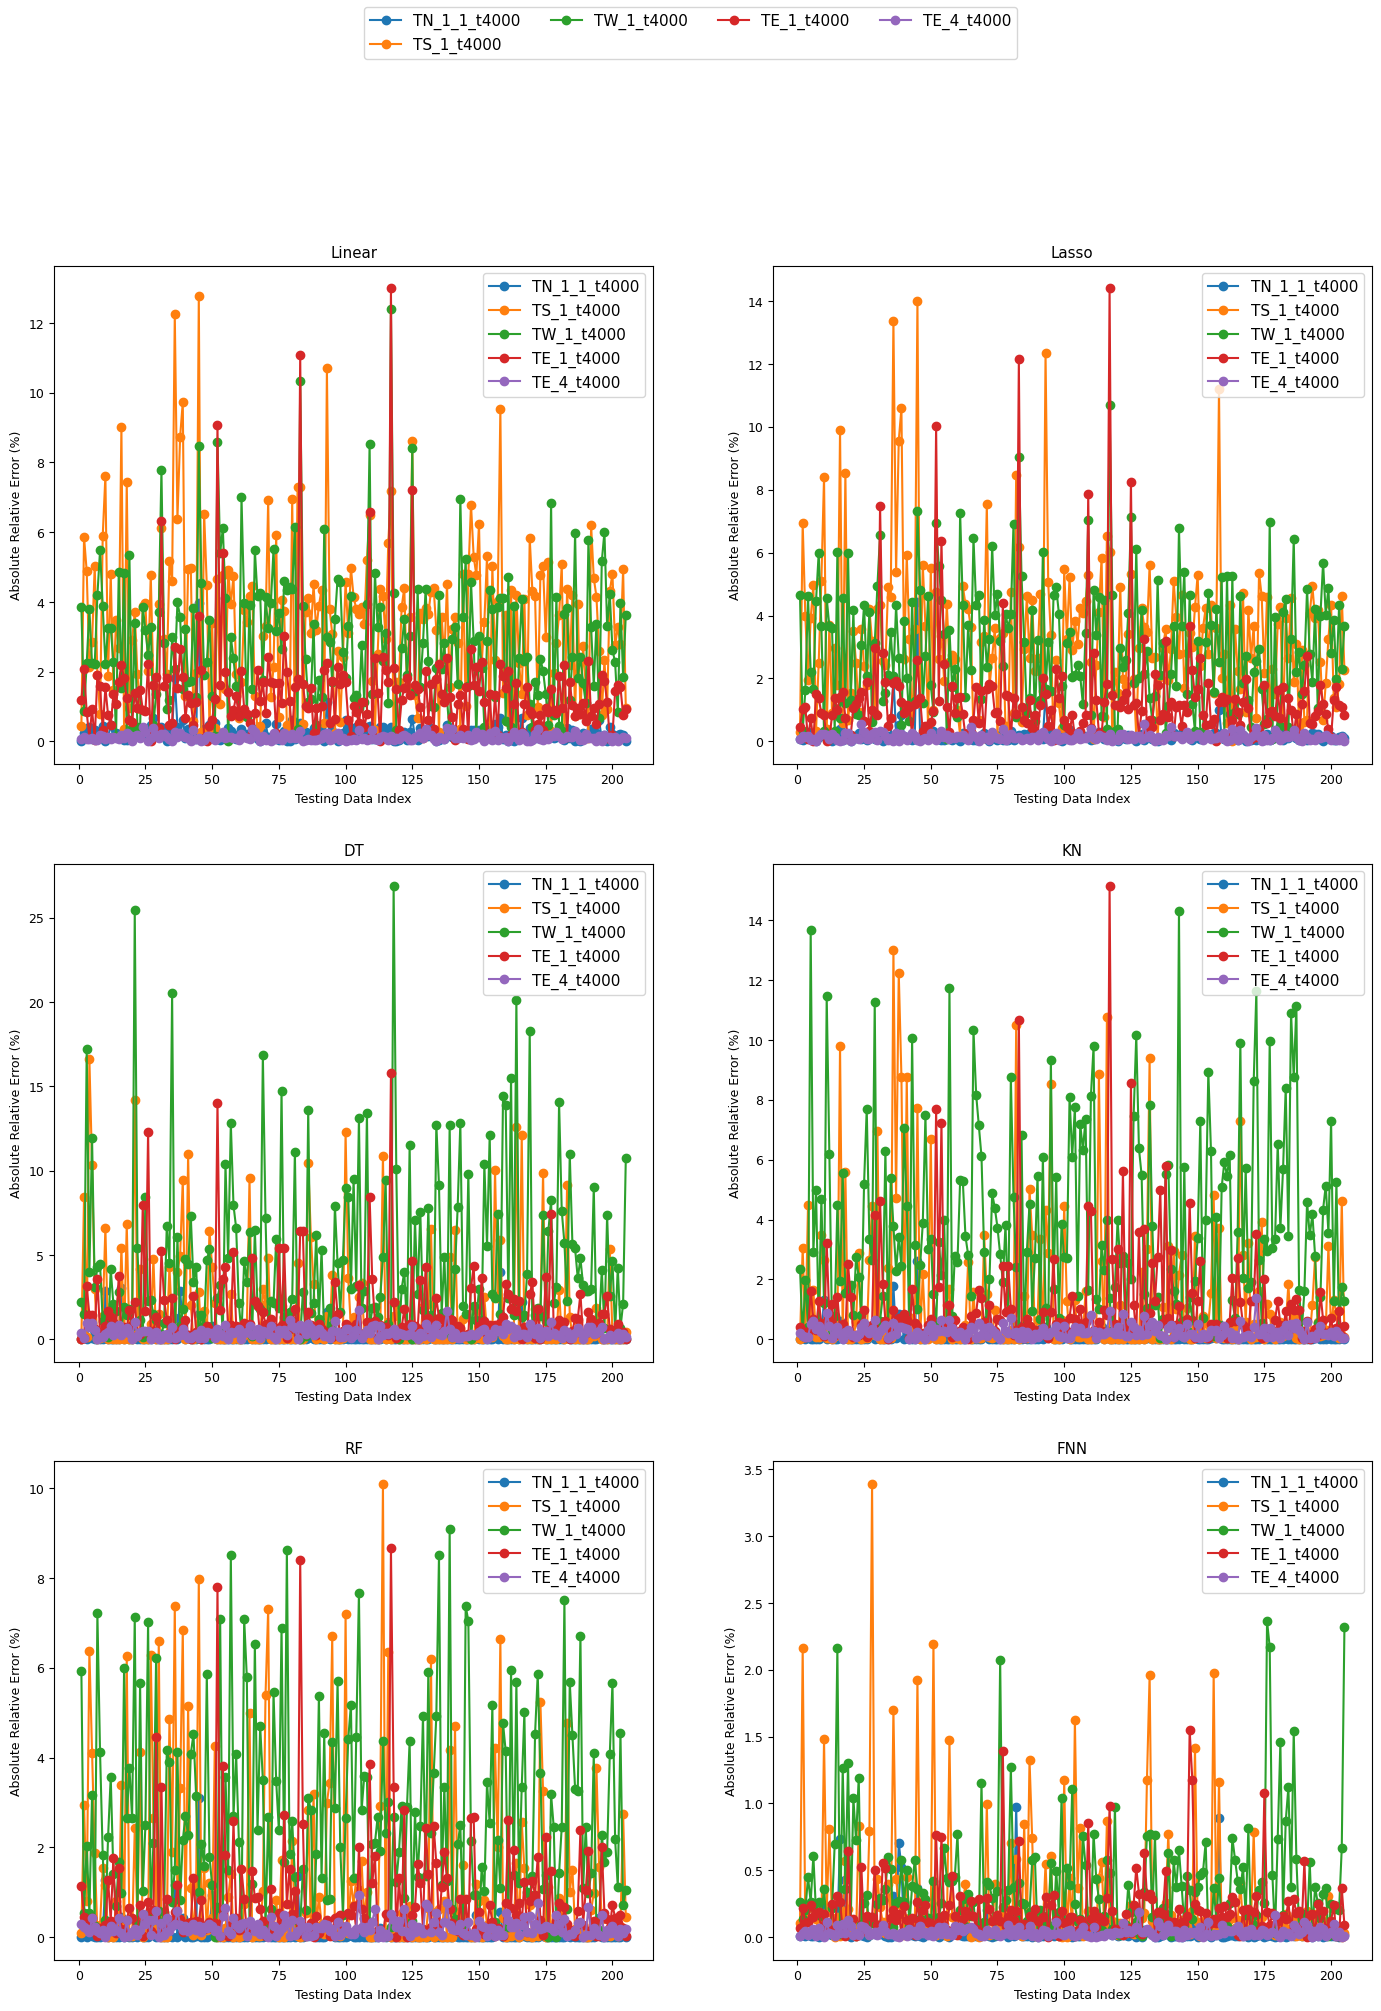

In [23]:
fig, axarr = plt.subplots(models.shape[0], models.shape[1], figsize=(17,22))

y = ["TN_1_1_t4000", "TS_1_t4000", "TW_1_t4000", "TE_1_t4000", "TE_4_t4000"]

for i in range(models.shape[0]):
    for j in range(models.shape[1]):
        plt.sca(axarr[i, j])
        axarr[i, j] = postprocessor.validation_plot(model_type=models[i, j], y=y)
        axarr[i, j].set_title(models[i, j])

fig.legend(y, loc="upper center", ncol=4)
fig.savefig('results/error_plot.png', dpi=300, bbox_inches='tight')

The diagonal validation and validation plots agree with the performance metrics. The FNN got at worst an absolute relative error of 2.5%, which is still really good.

To further understand the behavior of the top neural network configurations, we can plot the learning curve. Here, the top neural network learning curve is shown but, similar to the diagonal and validation plot functions, `pyMAISE.PostProcessor.nn_learning_plot` shows the neural network based on the index in `pyMAISE.PostProcessor.metrics` or, if no index is provided, the one with the best test $R^2$.

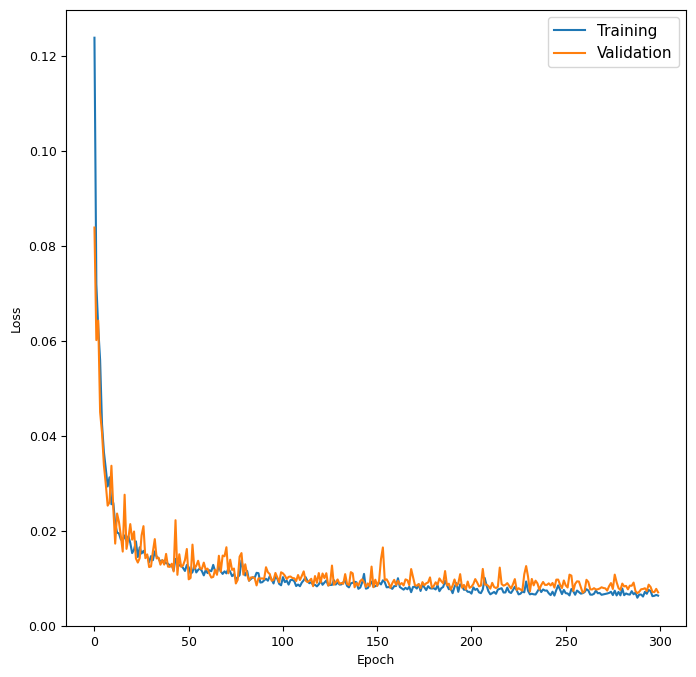

In [24]:
plt.figure()
postprocessor.nn_learning_plot()
plt.savefig('results/nn_learning.png', dpi=300, bbox_inches='tight')

The FNN is not overfitting, as the validation curve closely follows the training curve.